# COGS 108 - Final Project 

# Overview

For this project, I wanted to find out if there was any relationship between CES 2.0 Scores (used as a measurement of environmental healthiness) for San Diego parks designated to specific zip code regions and Yelp ratings. Two datasets examined had information about Yelp ratings for San Diego parks and CSE 2.0 Scores by county and zipcodes. From the analysis, there seemed to be a negative correlation between CSE 2.0 Scores and Yelp ratings, which meant that the more environmentally healthy the region a park was in, the higher it was rated on Yelp.

# Name & GitHub

- Name: Lei Lam
- GitHub Username: melam20

# Research Question

Does the environmental healthiness of San Diego parks improve their Yelp ratings?

## Background and Prior Work

Yelp reviews can help indicate public approval, which is important for allocating budgets for public parks. If the public is dissatisfied with a park for specific reasons, it's important to put funds into maintaining a park better.  

CalEnviroScreen, which generates CES 2.0 Scores, shows California regions most impacts by pollution, and the CES 2.0 Scores take into account environmental, health, and socioeconomic information [1]. A higher CES 2.0 score means that an area has more pollution burden, while a lower score means an area experiences less pollution burden [1]. Pollution burden means how much people are exposed to pollutants and negative environmental effects caused by pollution [2], so the CES 2.0 Scores will be used as indicators of environmental healthiness of parks in zip code regions defined by available CES 2.0 Scores. Additionally, environmental healthiness is important because pollution can cause park visitation to go down if air quality is too poor or uf there are environmental hazards that will cause health problems for people.

There has been similar work done on a national scale that documented and analyzed a relationship between national park visitation and air quality, with increases in air pollution causing drops in park visitation [3], [4]. The study by Cornell and Iowa Universities points out that visitors are aware of the poor air quality and avoid the parks [4], which may also indicate lower approval for the parks during these times.

References (include links):
- 1) https://oehha.ca.gov/calenviroscreen/about-calenviroscreen
- 2) https://oehha.ca.gov/calenviroscreen/pollution-indicators
- 3) https://advances.sciencemag.org/content/4/7/eaat1613
- 4) https://news.cornell.edu/stories/2018/07/visitors-avoid-national-parks-when-air-pollution-high

# Hypothesis


I hypothesize that lower CES 2.0 Scores will predict higher Yelp rating. As lower CES 2.0 Scores are indicators of better environmental healthiness of the parks in the zip code region, the parks in those regions will be rated higher due to this. People will enjoy parks in more environmentally healthy regions, so that is why the ratings will be higher.

# Dataset(s)

The ideal dataset for this question would have information about where each park was on a map based on zip code region, and there would be a CES 2.0 Score that would be associated with each region. Ideally, there would also be equal observations from each region for Yelp ratings and CES 2.0 Score reports, and they would all be from the same year.

The datasets were provided on Github by the instructor, so there are no links available for them.

Dataset 1
- Dataset Name: yelp_SD_parks.csv
- Link to the dataset: no link to the dataset
- Number of observations: 833 observations

This dataset provides information on San Diego parks like their names, addresses, websites, phone numbers, longitude/latitude for a map, Yelp ratings and review counts, and if they are open or closed.

Dataset 2
- Dataset Name: calenviroscreen-final-report.csv
- Link to the dataset: no link to the dataset
- Number of observations: 8035 observations

This dataset provides information across California counties and specific zip code regions about their environmental healthiness, described by their pollution burden and other factors (like traffic, toxic waste, pesticides, etc.). Each are given a score (CES Score) based on the combination of these factors as well as the population demographics.

I plan to combine these datasets in averaging ratings and CES scores across the zipcode regions.

# Setup

In [74]:
#import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import patsy
import statsmodels.api as sm

In [75]:
#reading in the datasets
df_yelp = pd.read_csv(r'C:\Users\Lei\Documents\individual_fa20\data\yelp_SD_parks.csv')
df_env = pd.read_csv(r'C:\Users\Lei\Documents\individual_fa20\data\calenviroscreen-final-report.csv')

# Data Cleaning

In [76]:
#clean df_yelp
df_yelp = df_yelp.drop(columns=['phone', 'id', 'url', 'longitude', 'latitude', 'is_closed', 'review_count'])
df_yelp = df_yelp.rename(columns={'address' : 'zip'})

#removing the leading digits and getting zip codes only
if df_yelp.loc[656,:].values[0] == 'Stonewall Peak Trail':
    df_yelp.loc[656, 'zip'] = df_yelp.loc[656, 'zip'][-5:]

if df_yelp.loc[556,:].values[0] == 'Parque Teniente Guerrero':
    df_yelp.loc[556, 'zip'] = df_yelp.loc[556, 'zip'][-5:]
    
if df_yelp.loc[312,:].values[0] == 'Arco del Milenio':
    df_yelp.loc[312, 'zip'] = df_yelp.loc[312, 'zip'][-5:]

df_yelp['zip'] = df_yelp['zip'].str.replace('-', '')
df_yelp['zip'] = df_yelp['zip'].str.replace('^\d+\s+', '')    
df_yelp['zip'] = df_yelp['zip'].str.extract(r'(\d{5}\-?\d{0,4})')

#dropping missing values
df_yelp = df_yelp.dropna()

#sorting numerically by zipcode
df_yelp = df_yelp.sort_values(by='zip')

#resetting the index
df_yelp.reset_index(drop=True)

#getting zip codes into a list format
yelp_zip_list = list(df_yelp['zip'])

In [77]:
#clean df_env
df_env = df_env.drop(columns=['Census Tract', 'Total Population', 'Click for interactive map', 'Hyperlink', 
        'Ozone', 'Ozone Pctl', 'PM2.5', 'Diesel PM', 'Diesel PM Pctl', 'Drinking Water', 'Drinking Water Pctl',
        'Pesticides', 'Pesticides Pctl', 'Tox. Release', 'Tox. Release Pctl', 'Traffic', 'Traffic Pctl',
        'Cleanup Sites', 'Cleanup Sites Pctl', 'Groundwater Threats', 'Groundwater Threats Pctl', 'Haz. Waste',
        'Haz. Waste Pctl', 'Imp. Water Bodies', 'Imp. Water Bodies Pctl', 'Solid Waste', 'Solid Waste Pctl',
        'Age', 'Age Pctl', 'Asthma', 'Asthma Pctl', 'Low Birth Weight', 'Low Birth Weight Pctl', 'Education',
        'Education Pctl', 'Linguistic Isolation', 'Linguistic Isolation Pctl', 'Poverty', 'Poverty Pctl',
        'Unemployment', 'Unemployment Pctl', 'Pop. Char. ', 'Pop. Char. Score', 'Pop. Char. Pctl',
        'CES 2.0 Percentile Range', 'PM2.5 Pctl', 'Pollution Burden', 'Pollution Burden Score',
        'Pollution Burden Pctl'])
df_env = df_env.rename(columns={'CES 2.0 Score' : 'CES'})

#get only San Diego info
df_env_sd = df_env[df_env['California County'] == 'San Diego']

#clean df_env_sd
df_env_sd = df_env_sd.rename(columns={'Location 1' : 'zip'})
df_env_sd['zip'] = df_env_sd['zip'].str.extract(r'(\d{5}\-?\d{0,4})')

#sorting numerically by zipcode
df_env_sd = df_env_sd.sort_values(by='zip')

#resetting the index
df_env_sd.reset_index(drop=True)

#getting zip codes into a list format
env_zip_list = list(df_env_sd['zip'])

In [78]:
#getting the different zip codes between the two zip code lists
new_list = list(set(yelp_zip_list).difference(env_zip_list))
new_list_2 = list(set(env_zip_list).difference(yelp_zip_list))

#dropping differences from the yelp zip list
df_yelp = df_yelp[~df_yelp.zip.isin(new_list)]

#dropping differences from the env zip list
df_env_sd = df_env_sd[~df_env_sd.zip.isin(new_list_2)]

In [79]:
#adding the ratings by zip code for yelp
yelp_sum_of_rate = list(df_yelp.groupby('zip')['rating'].sum())

#getting how many ratings there are per zip code (how many parks per zip code) for yelp
yelp_num_of_zips = list(df_yelp.groupby('zip')['rating'].count())

#find the average rating across the parks in the same zipcode for yelp
avg_rating_yelp = []
items = 0

while (items < 76):
    avg_rating_yelp.append(yelp_sum_of_rate[items]/yelp_num_of_zips[items])
    items = items+1

In [80]:
#adding the CES Scores by zip code for env
env_sum_of_CES = list(df_env_sd.groupby('zip')['CES'].sum())

#getting how many CES Scores there are per zip code
env_num_of_CES = list(df_env_sd.groupby('zip')['CES'].count())

#find the average CES across the parks in the same zipcode for env
avg_rating_env = []
items = 0

while (items < 76):
    avg_rating_env.append(env_sum_of_CES[items]/env_num_of_CES[items])
    items = items+1

In [83]:
#putting avg lists into dataframe
avg_df = pd.DataFrame(list(zip(avg_rating_yelp, avg_rating_env)),
                     columns=['avg_rating', 'avg_CES_Score'])

Text(0.5, 1.0, 'Relationship Between Average CES 2.0 Scores and Average Yelp Ratings per Zip Code Region')

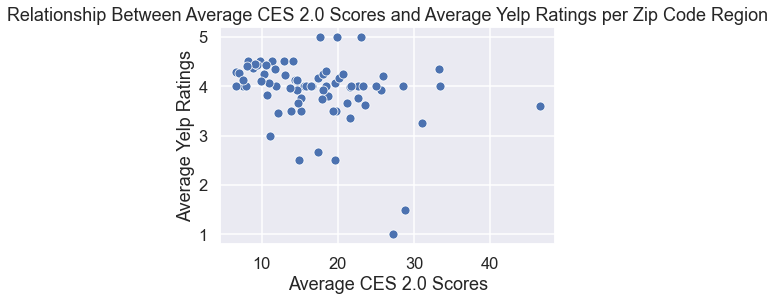

In [88]:
#each dot reprsents a zipcode region
sns.scatterplot(x=avg_df['avg_CES_Score'], y=avg_df['avg_rating'])

plt.xlabel('Average CES 2.0 Scores')
plt.ylabel('Average Yelp Ratings')
plt.title('Relationship Between Average CES 2.0 Scores and Average Yelp Ratings per Zip Code Region')

Text(0.5, 1.0, 'Zip Code Ranges and Instances')

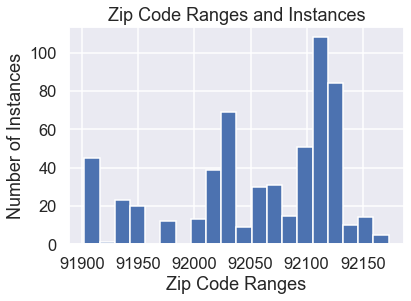

In [92]:
#checking zip code ranges with how many instances of each
df_env_sd['zip'] = df_env_sd['zip'].astype(float)
df_env_sd['zip'].plot.hist(bins=20)

plt.xlabel('Zip Code Ranges')
plt.ylabel('Number of Instances')
plt.title('Zip Code Ranges and Instances')

# Data Analysis & Results

Text(0.5, 1.0, 'Average Ratings Across Zip Code Regions')

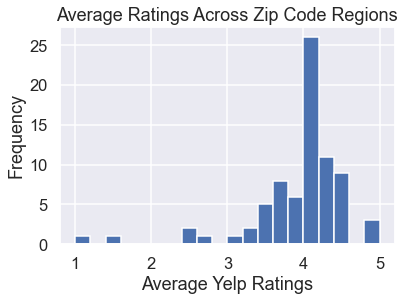

In [91]:
#how many average ratings
avg_df['avg_rating'].plot.hist(bins=20)

plt.xlabel('Average Yelp Ratings')
plt.ylabel('Frequency')
plt.title('Average Ratings Across Zip Code Regions')

Text(0.5, 1.0, 'Average CES 2.0 Scores Across Zip Code Regions')

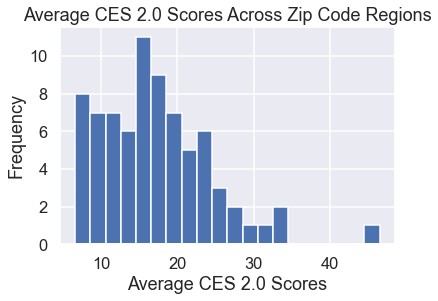

In [97]:
#how many average CES 2.0 Scores
avg_df['avg_CES_Score'].plot.hist(bins=20)

plt.xlabel('Average CES 2.0 Scores')
plt.ylabel('Frequency')
plt.title('Average CES 2.0 Scores Across Zip Code Regions')

In [64]:
#linear regression model
outcome, predictors = patsy.dmatrices('avg_rating~avg_CES_Score', avg_df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     7.269
Date:                Mon, 14 Dec 2020   Prob (F-statistic):            0.00868
Time:                        13:05:30   Log-Likelihood:                -70.299
No. Observations:                  76   AIC:                             144.6
Df Residuals:                      74   BIC:                             149.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3701      0.182     23.987

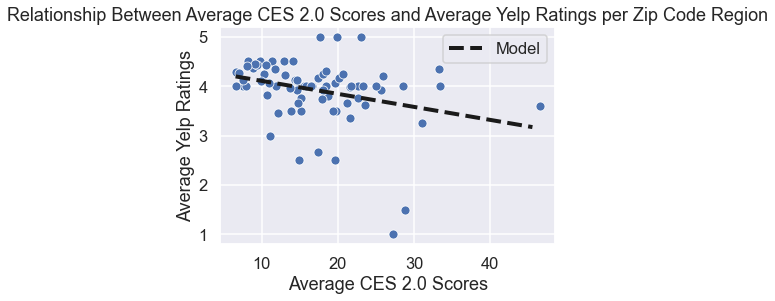

In [101]:
#plotting orignal average data scatterplot again
sns.scatterplot(x='avg_CES_Score', y='avg_rating', data=avg_df)

#model fit line
xs = np.arange(avg_df['avg_CES_Score'].min(), avg_df['avg_CES_Score'].max())
ys = -0.0263 * xs + 4.3701
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('Average CES 2.0 Scores')
plt.ylabel('Average Yelp Ratings')
plt.title('Relationship Between Average CES 2.0 Scores and Average Yelp Ratings per Zip Code Region')
plt.legend();

Based on the model fit line generated by this linear regression model, it seems there is some negative correlation between the average CSE 2.0 scores and average Yelp ratings in zip code regions. Lower CES 2.0 Scores seem to correspond to higher Yelp ratings.

# Ethics & Privacy

The datasets were provided by the instructor to use, so I had permission to use the datasets for this project. The Yelp ratings are also public, and the dataset already had no personal data of the people who had rated or left reviews, so there was no potential breach of privacy. The CES Report dataset was also public and available from the California Envrionmental Health Screening website, and there was no personal information listed in the report, as it was all compiled into a county-level analysis.


Potential bias might have affected the CES 2.0 Scores because population characteristics are also taken into account when developing the score, and if not everyone was counted in the census per counties that were listed on the report, then those people's data would not be accounted for in the final report. There is also potential bias in the fact that there was no controlling for how many people could leave ratings on Yelp for parks, and that maybe some parks received more ratings than others. Similarly, some zip code regions in the San Diego county for the CES Report could have had more observations than others.

A possible unintentional result of this analysis might be skewing park visitation to the parks with better environmental healthiness and more funding being put into those parks. Although it should be that all parks receive the same funding, it ultimately depends on who is in the department for budgeting, and they could use this data to maintain parks which are more favored by the public, which makes it difficult to potentially address and right this.

# Conclusion & Discussion

In this project, I looked at averaged CES 2.0 Scores and averaged Yelp ratings to see if there was a relationship between them that would indicate that better environmental healthiness, or lower CES 2.0 Scores, lead to higher rated parks in specific zip code regions. I focused only on the San Diego County data from the CES Report dataset by dropping all the other columns that were from different counties. I dropped other irrelevant columns from both datasets to focus on the zip codes that would match from both datasets, so that the averaged CES 2.0 Scores and Yelp ratings from each zip code region could be compared. I found there was a negative correlation between the averaged CES 2.0 Scores and Yelp ratings, which supported the hypothesis that better environmental healthiness would lead to higher Yelp ratings.

One limitation of this project is that I averaged across zip code regions for the park ratings and the CES 2.0 Scores because This makes it difficult to say that each park may be affected by the same pollution factors, and that environmental healthiness across all the parks in the same zip code region is the same. This linear regression model may not have been the most effective approach since I do not think there is specific CES 2.0 Scores that pertained to each park. This was an issue because I had to average since there was not just one instance of a score for some zip codes, so this made a merge inaccurate. I also dropped three park data that had missing zip code data. Another limitation is that people may not be visiting the same park every time they do go to a public park, and they may have rated the park at a different time then when the CES Report was done (in 2010). They also may have just rated the park once based off one experience and never changed their rating afterward on Yelp.

The project might be helpful for those in charge of budgeting for Parks and Recreation as well as the San Diego county's Environmental Healthiness Department to figure out how to put funds into certain parks in regions that may have lower scores and impacted park rating approval. It could advise them to look into some parks in areas with worse environmental health to address underlying pollution or detrimental environemental problems.